Trial 90 Complete [00h 00m 25s]
val_mae: 0.014229112304747105

Best val_mae So Far: 0.011887583881616592
Total elapsed time: 00h 20m 23s


Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.3785 - mae: 0.3785 - val_loss: 0.0370 - val_mae: 0.0370
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1138 - mae: 0.1138 - val_loss: 0.0761 - val_mae: 0.0761
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0504 - mae: 0.0504 - val_loss: 0.0202 - val_mae: 0.0202
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0212 - val_mae: 0.0212
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0205 - val_mae: 0.0205
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0166 - val_mae: 0.0166
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0387 - mae: 0.0387 - val_loss: 0.0587 - val_mae: 0.0587
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0450 - mae: 0.0450 - val_loss: 0.0454 - val_mae: 0.0454
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - lo

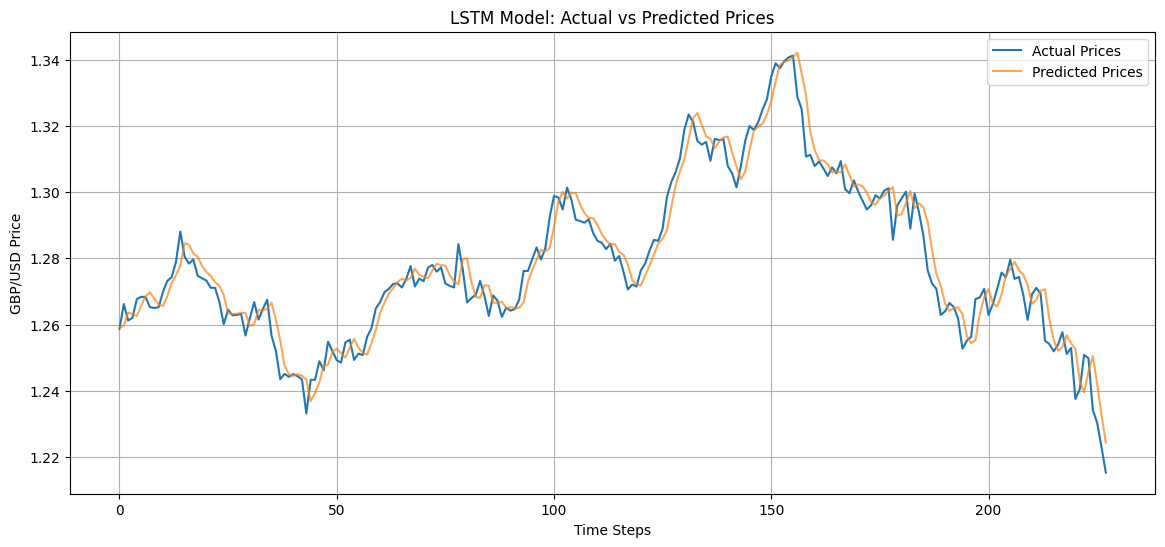

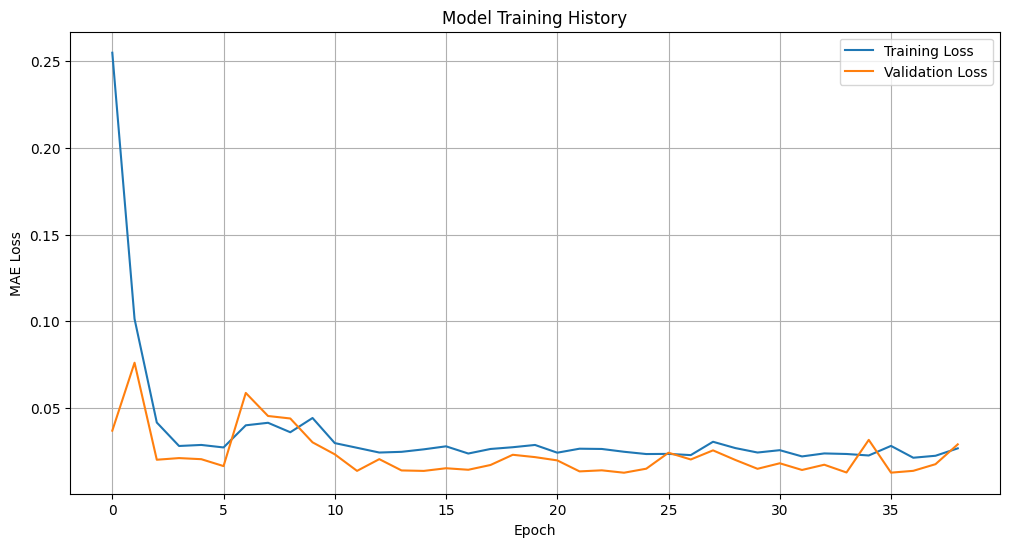

Model saved as 'lstm_gbpusd_predictor.h5'


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import Hyperband
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv("./training_data/GBPUSD_open_5year.csv")
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.sort_values('Date', inplace=True)
prices = data['Open'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

# Create time series sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # Using 60 days as historical window
X, y = create_sequences(scaled_prices, SEQ_LENGTH)

# Train-test split (time-series aware)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Hyperparameter tuning
def build_model(hp):
    model = keras.Sequential()
    
    # Tune LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 3)):
        model.add(layers.LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            return_sequences=i < hp.get('num_lstm_layers')-1,
            input_shape=(SEQ_LENGTH, 1) if i == 0 else None
        ))
        model.add(layers.Dropout(
            hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Tune dense layers
    for j in range(hp.Int('num_dense_layers', 0, 2)):
        model.add(layers.Dense(
            units=hp.Int(f'dense_units_{j}', min_value=16, max_value=128, step=16),
            activation=hp.Choice(f'dense_act_{j}', ['relu', 'tanh'])
        ))
    
    model.add(layers.Dense(1))
    
    # Tune learning rate
    lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='mae',
        metrics=['mae']
    )
    return model

tuner = Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=50,
    factor=3,
    directory='lstm_tuning',
    project_name='gbpusd_lstm'
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    restore_best_weights=True,
    monitor='val_mae'
)

# Hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    batch_size=64,
    verbose=1
)

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Train final model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test)
y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f"\nTest MAE: {mae:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(y_pred_actual, label='Predicted Prices', alpha=0.7)
plt.title('LSTM Model: Actual vs Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('GBP/USD Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save model
model.save('lstm_gbpusd_predictor.h5')
print("Model saved as 'lstm_gbpusd_predictor.h5'")